# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook series, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook series are:


- Notebook 1: Data Ingestion 
    1. Install custom libraries
    2. Load the data 

- Notebook 2:<br>
    3. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature. 

- Notebook 3: <br>
    4. Train machine learning models using `Scikit-Learn` and `LightGBM`, and track experiments using MLflow and Fabric Autologging feature.
    5. Evaluate and save the final machine learning model

- Notebool 4:<br>
	6. load the best model to run predicitons.


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

### Imports and Parameters

In [6]:
import joblib
import inspect
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 10, Finished, Available, Finished)

Define these parameters, so that you can use this notebook with different datasets or [Assign parameters values from a pipeline](https://learn.microsoft.com/en-us/fabric/data-engineering/author-execute-notebook#assign-parameters-values-from-a-pipeline).

In [7]:
TARGET = "Exited" # Dependent (target) attribute
EXPERIMENT_NAME = "bank-churn"  # Mlflow  experiment name
INPUT_TABLE_NAME = "silver/churn"
OUTPUT_TABLE_PREFIX = "churn"

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 11, Finished, Available, Finished)

## Step 4: Model training and tracking


With the data in place, you can now define the model. Apply random forest and LightGBM models in this notebook.

Use the scikit-learn and LightGBM libraries to implement the models, with a few lines of code. Additionally, use MLfLow and Fabric Autologging to track the experiments.

This code sample loads the delta table from the lakehouse. You can use other delta tables that themselves use the lakehouse as the source.

In [8]:
df_clean = spark.read.format("delta").load(f"Tables/{INPUT_TABLE_NAME}").toPandas()

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 12, Finished, Available, Finished)

### Generate an experiment for tracking and logging the models by using MLflow

This section shows how to generate an experiment, and it specifies the model and training parameters and the scoring metrics. Additionally, it shows how to train the models, log them, and save the trained models for later use.

### Set experiment and autologging specifications


In [9]:
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(exclusive=False)

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 13, Finished, Available, Finished)

2024/10/10 06:35:17 INFO mlflow.tracking.fluent: Experiment with name 'bank-churn' does not exist. Creating a new experiment.


Autologging automatically captures both the input parameter values and the output metrics of a machine learning model, as that model is trained. This information is then logged to your workspace, where the MLflow APIs or the corresponding experiment in your workspace can access and visualize it.

When complete, your experiment resembles this image:

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/experiment_runs.png"  width="70%" height="10%" title="Screenshot shows the experiment page for the bank-churn-experiment.">

All the experiments with their respective names are logged, and you can track their parameters and performance metrics. To learn more about autologging, see [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).


### Import scikit-learn and LightGBM

In [10]:

# Import the required libraries for data transformation
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler

# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 14, Finished, Available, Finished)

2024/10/10 06:35:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/10 06:35:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Prepare training, validation and test datasets

In [11]:
y = df_clean[TARGET]
X = df_clean.drop(TARGET, axis=1)
# Train/test separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
# Train-Validation Separation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train)

print(f"Training dataset: {len(X_train)} | {100* len(X_train)/len(df_clean)}%")
print(f"Validation dataset: {len(X_val)} | {100* len(X_test)/len(df_clean)}%")
print(f"Test dataset: {len(X_test)} | {100* len(X_test)/len(df_clean)}%")

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 15, Finished, Available, Finished)

Training dataset: 3000 | 60.0%
Validation dataset: 1000 | 20.0%
Test dataset: 1000 | 20.0%


### Save test data

Save the test data to delta table for model evaluation and use in next notebook.

In [12]:
table_name = f"gold/{OUTPUT_TABLE_PREFIX}_test"
# Create PySpark DataFrame from Pandas
df_test=spark.createDataFrame(X_test)
df_test.write.mode("overwrite").option("overwriteSchema", "true").format("delta").save(f"Tables/{table_name}")
print(f"Spark test DataFrame saved to delta table: {table_name}")

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 16, Finished, Available, Finished)

Spark test DataFrame saved to delta table: gold/churn_test


### Apply SMOTE to the training data

Imbalanced classification has a problem, because it has too few examples of the minority class for a model to effectively learn the decision boundary. To handle this, Synthetic Minority Oversampling Technique (SMOTE) is the most widely used technique to synthesize new samples for the minority class. Access SMOTE with the `imblearn` library that you installed in step 1.

<mark>Apply SMOTE only to the training dataset</mark>. You must leave the test dataset in its original imbalanced distribution, to get a valid approximation of model performance on the original data. This experiment represents the situation in production.

For more information, see [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [From random over-sampling to SMOTE and ADASYN](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn). The imbalanced-learn website hosts these resources.

In [13]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X_train, y_train)

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 17, Finished, Available, Finished)

2024/10/10 06:35:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '037a97e2-ceda-4bf5-a7bd-f2eb7fc17694', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-10-10:06:35:38,609 WARNING  [tracking_store.py:153] log_inputs not supported
2024/10/10 06:35:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/10/10 06:35:39 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/10/10 06:35:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/10 06:35:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/ho

### Train the models

Use Random Forest to train the model, with a maximum depth of four, and with four features:

In [14]:
model_name = "rfc1_sm"
# Register the trained model with autologging
mlflow.sklearn.autolog(
    registered_model_name=model_name, 
    silent=True, 
    log_input_examples=True,
    log_models=True)

# Create the model
rfc1_model = RandomForestClassifier(
    max_depth=4,
    max_features=4,
    min_samples_split=3,
    random_state=1,
)    
with mlflow.start_run(run_name=model_name) as run:
    # Capture run_id for model prediction later
    rfc1_run_id = run.info.run_id
    print(f"run_id: {rfc1_run_id}; status: {run.info.status}")
    
    # fit with balanced training data
    rfc1_model.fit(X_res, y_res.ravel())
    rfc1_model.score(X_val, y_val)
    y_pred = rfc1_model.predict(X_val)
    cr = classification_report(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, rfc1_model.predict_proba(X_val)[:, 1])

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 18, Finished, Available, Finished)

run_id: 97eda483-11c0-44b8-924e-b7b5caa0a3d6; status: RUNNING


2024-10-10:06:35:51,65 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:35:57,87 ERROR    [synapse_mlflow_utils.py:413] [fabric mlflow plugin]: <class 'mlflow.store.model_registry.rest_store.RestStore'>.create_model_version exception PERMISSION_DENIED: Response: {'Message': 'User does not have permission to perform this operation.', 'Source': 'ML', 'error_code': 'PERMISSION_DENIED'}


### View the experiment artifact to track model performance

The experiment runs are automatically saved in the experiment artifact. You can find that artifact in the workspace. An artifact name is based on the name used to set the experiment. All of the trained models, their runs, performance metrics and model parameters are logged on the experiment page.

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case, **bank-churn-experiment**.

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/experiment_runs.png"  width="80%" title="Screenshot shows logged values for one of the models.">

## Specific data preprocessing

Some models or data might require specific preprocessing step which depend on the distribution of the training data. Because data distribution might change over time (data drift), it is recommended to manage those transformation steps with the model, not sharing them with other experiments. We use `sklearn.compose.ColumnTransformer` to create the feature transformations, such as scaling or binning. Later we include those transformations with the model in an `sklean.pipeline`. 

In [15]:
def get_transformers():
    col_transformer = make_column_transformer(
            (MinMaxScaler(feature_range=(0, 21)), ["Tenure", "CreditScore"]),
            (StandardScaler(), ["CreditScore", "Age"]),
            (KBinsDiscretizer(n_bins=21, encode="ordinal", strategy="quantile"), ["EstimatedSalary", "Balance"]),
        remainder="passthrough"
    )
    return col_transformer

get_transformers()

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 19, Finished, Available, Finished)

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(feature_range=(0, 21)),
                                 ['Tenure', 'CreditScore']),
                                ('standardscaler', StandardScaler(),
                                 ['CreditScore', 'Age']),
                                ('kbinsdiscretizer',
                                 KBinsDiscretizer(encode='ordinal', n_bins=21),
                                 ['EstimatedSalary', 'Balance'])])

### Train a model pipeline
Specify a data training objective function 

In [16]:
from mlflow.models import infer_signature


def train_pipeline(model, run_name: str, **fit_kwargs):
    with mlflow.start_run(run_name=run_name) as run:
        # Capture run_id for model prediction later
        run_id = run.info.run_id
        print(f"run_id: {run_id}; status: {run.info.status}")
        
        # Fit and run data transformation  
        transfomers = get_transformers()
        transfomers.fit(X_train)
        X_res_tf = transfomers.transform(X_res)
        X_val_tf = transfomers.transform(X_val)
        
        # Add feature names to fit_kwargs, if supported by method
        sig = inspect.signature(model.fit)
        if 'feature_name' in sig.parameters:
            fit_kwargs['feature_name'] = transfomers.get_feature_names_out().tolist()

        # fit with balanced training data
        model.fit(X_res_tf, y_res.ravel(), **fit_kwargs)
        model.score(X_val_tf, y_val)
        y_pred = model.predict(X_val_tf)
        cr = classification_report(y_val, y_pred)
        cm = confusion_matrix(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, model.predict_proba(X_val_tf)[:, 1])

        # log the sklearn model pipeline artifact to mlflow
        signature = infer_signature(model_input=X_train, model_output=y_pred)
        mlflow.sklearn.log_model(
            sk_model=Pipeline([
                ('preprocessor', transfomers),
                ('classifier', model)]),
            artifact_path='model',
            signature=signature,
            registered_model_name=run_name)
        return run_id

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 20, Finished, Available, Finished)

Use Random Forest to train the model, with a maximum depth of eight, and with six features:

In [17]:
model_name = "rfc2_sm"
# Register the trained model with autologging
mlflow.sklearn.autolog(
    silent=True, 
    log_input_examples=False,
    log_models=False)

# Create the model
rfc2_model = RandomForestClassifier(
    max_depth=8, 
    max_features=6, 
    min_samples_split=3, 
    random_state=1,
)

rfc2_run_id = train_pipeline(model=rfc2_model, run_name=model_name);

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 21, Finished, Available, Finished)

run_id: d605f503-50ca-420a-8f83-9887c6bd8f3a; status: RUNNING


/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
2024-10-10:06:36:01,43 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:36:04,942 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:36:04,998 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that i

Train the model with LightGBM.

><mark>NOTE:</mark>\
>We change the mlflow flavor for autolog because LightGBM has its own model flavor.


In [18]:
# lgbm_model
model_name = "lgbm_sm"
# Register the trained model with autologging
mlflow.lightgbm.autolog(
    silent=True, 
    log_input_examples=False,
    log_models=False)
# Create the model  
lgbm_model = LGBMClassifier(
    learning_rate=0.07,
    max_delta_step=2,
    n_estimators=100,
    max_depth=10,
    eval_metric="logloss",
    objective="binary",
    random_state=42,
    verbose=-1,
)
# combine transformation and model to an estimator pipeline 

lgbm_run_id = train_pipeline(model=lgbm_model, run_name=model_name);

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 22, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:313: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
2024-10-10:06:36:20,135 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:36:21,988 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:36:22,29 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/clonedenv/lib/python3.10/site-packages/mlflow/models/signature.py:214: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that i

run_id: 608946ba-3ff1-4254-a2ae-64d614d5ffdd; status: RUNNING


## Step 5: Evaluate the final machine learning models


With Mlflow, models can be shared and versioned without having to reference the experiment or run. For this purpose, the name and version of the model are stored and managed in the model registry. The model registry enables secure access to models beyond your own workspace.

By specifying the `registered_model_name` attribute, we have already registered our models in the model registry during training. This enables us to access the models created here in the subsequent inference step.

To view your registered models:

1. On the left panel, select your workspace.
2. Find and select the model name, in this case, **lgbm_sm**.


><mark>NOTE: </mark> \
>If your models are registered for the first time, you might have to refresh your browser window in order to see them.\
>If you only see the experiments but not the model, it means that the models are not registered. You can 
> - use the `mlflow.model_register()` function to register your models (see: [mlflow API documentation](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.register_model)). 
> - manually got to the experiment from the workspace, select the best model and click **Save as ML model**. This will register the model in your workspace under a name you provided.


### Load models by model URI

All models from the experiment are accessible in your workspace by calling them by the corresponding model URI:

><mark>NOTE: </mark> \
>The `mlflow.sklearn` model flavor is used to load the models because they are wrapped in `sklearn.pipeline` objects. 

In [19]:
# Fetch the model from the run_uri
load_model_rfc1 = mlflow.sklearn.load_model(f"runs:/{rfc1_run_id}/model")
load_model_rfc2 = mlflow.sklearn.load_model(f"runs:/{rfc2_run_id}/model")
load_model_lgbm = mlflow.sklearn.load_model(f"runs:/{lgbm_run_id}/model")

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 23, Finished, Available, Finished)

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 30, Finished, Available, Finished)

### Assess the performance of the saved models on the testing dataset

In [20]:
# Random forest with maximum depth of 4 and 4 features
ypred_rfc1 = load_model_rfc1.predict(X_val)
# Random forest with maximum depth of 8 and 6 features
ypred_rfc2 = load_model_rfc2.predict(X_val)
# LightGBM
ypred_lgbm = load_model_lgbm.predict(X_val)

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 24, Finished, Available, Finished)

2024-10-10:06:36:39,705 WARNING  [tracking_store.py:153] log_inputs not supported
2024-10-10:06:36:39,745 WARNING  [tracking_store.py:153] log_inputs not supported


### Show true/false positives/negatives by using a confusion matrix

To evaluate the accuracy of the classification, build a script that plots the confusion matrix. You can also plot a confusion matrix using SynapseML tools, as shown in the [Fraud Detection sample](https://aka.ms/samples/frauddectection).

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(estimator, X, y, title="Confusion matrix", **kwargs):
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay.from_estimator(estimator, X, y,
            display_labels=['Non Churn','Churn'] ,
            labels=sorted(y.unique()), xticks_rotation=45, cmap='Blues', ax=ax)
    plt.yticks(rotation=45)
    plt.title(title, fontsize=10)
    plt.show()

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 25, Finished, Available, Finished)

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 26, Finished, Available, Finished)

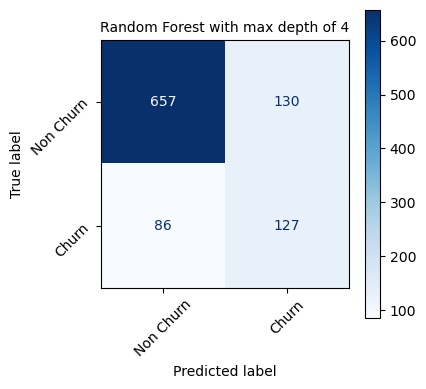

In [22]:
# Computing and display the confusion matrix
plot_confusion_matrix(
    estimator=load_model_rfc1,
    X=X_val,
    y=y_val,
    title="Random Forest with max depth of 4",
)

Create a confusion matrix for the random forest classifier with maximum depth of eight, with six features:

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 27, Finished, Available, Finished)

2024-10-10:06:36:42,881 WARNING  [tracking_store.py:153] log_inputs not supported


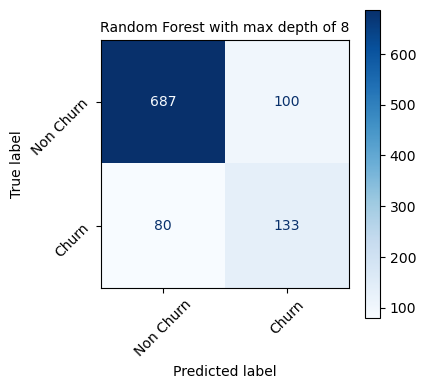

In [23]:
# Computing and display the confusion matrix
plot_confusion_matrix(
    estimator=load_model_rfc2,
    X=X_test,
    y=y_test,
    title="Random Forest with max depth of 8",
)

Create a confusion matrix for LightGBM:

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 28, Finished, Available, Finished)

2024-10-10:06:36:44,92 WARNING  [tracking_store.py:153] log_inputs not supported


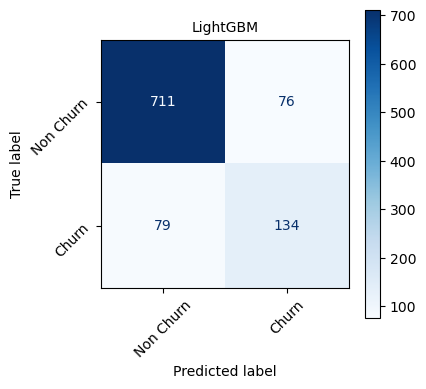

In [24]:
plot_confusion_matrix(
    estimator=load_model_lgbm,
    X=X_test,
    y=y_test,
    title="LightGBM",
)

-----


### Save results for Power BI

Save the delta frame to the lakehouse, to move the model prediction results to a Power BI visualization.

In [25]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1'] = ypred_rfc1
df_pred['ypred_rfc2'] =ypred_rfc2
df_pred['ypred_lgbm'] = ypred_lgbm
table_name = "df_pred_results"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")
print(f"Spark DataFrame saved to delta table: {table_name}")

StatementMeta(, 964dea63-5079-44f8-a277-744a25eabda2, 29, Finished, Available, Finished)

Spark DataFrame saved to delta table: df_pred_results


## Optional: Access visualizations in Power BI

Access your saved table in Power BI:

1. On the left, select **OneLake data hub**
1. Select the lakehouse that you added to this notebook
1. In the **Open this Lakehouse** section, select **Open**
1. On the ribbon, select **New semantic model**. Select `df_pred_results`, and then select **Continue** to create a new Power BI semantic model linked to the predictions
1. Select **New report** from the tools at the top of the semantic models page, to open the Power BI report authoring page

The following screenshot shows some example visualizations. The data panel shows the delta tables and columns to select from a table. After selection of appropriate category (x) and value (y) axis, you can choose the filters and functions - for example, sum or average of the table column.

> [!NOTE]
> In this screenshot, the illustrated example describes the analysis of the saved prediction results in Power BI:

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/PBIviz3.png"  width="100%" height="100%" title="Screenshot shows a Power BI dashboard example.">

However, for a real customer churn use-case, the user might need a more thorough set of requirements of the visualizations to create, based on subject matter expertise, and what the firm and business analytics team and firm have standardized as metrics.

The Power BI report shows that customers who use more than two of the bank products have a higher churn rate. However, few customers had more than two products. (See the plot in the bottom left panel.) The bank should collect more data, but should also investigate other features that correlate with more products.

Bank customers in Germany have a higher churn rate compared to customers in France and Spain. (See the plot in the bottom right panel). Based on the report results, an investigation into the factors that encouraged customers to leave might help.

There are more middle aged customers (between 25-45) and customers between 45-60 tend to exit more.

Finally, customers with lower credit scores would most likely leave the bank for other financial institutions. The bank should explore ways to encourage customers with lower credit scores and account balances to stay with the bank.